Let's make a pass at defining an eclipsing binary metric

`rubin_sim` install instructions at:  https://github.com/lsst/rubin_sim

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import os

In [2]:
baseline_file = get_baseline()
run_name = os.path.basename(baseline_file).replace('.db', '')

In [3]:
class EclipsingBinaryMetric(maf.BaseMetric):
    """First pass at eclipsing binary
    
    Parameters
    ----------
    period : float (10)
        The period of the star (days).
    time_in_eclipse : float (0.1)
        The length of the eclipse period (days).
    eb_mag : float (15)
        The usual magnitude of the EB (assuming flat SED for now, can
        can upgrade to a stellar type later). Not doing anything for dust now.
    snr_limit : float (5)
        Only consider observations above some SNR limit (unitless)
    num : int (1000)
        Number of points to interpolate light curve onto
    obs_needed : int (3)
        Number of points in eclipse to demand to consider EB detected
    """
    def __init__(self, m5_col='fiveSigmaDepth', mjd_col='observationStartMJD',
                 filter_col='filter', metric_name="EB Fraction",
                 eb_mag=15., period=10, time_in_eclipe=0.1, 
                 snr_limit=5., num=1000, 
                 obs_needed=3, **kwargs):
        
        self.mjd_col = mjd_col
        self.m5_col = m5_col
        self.filter_col = filter_col
        
        self.period = period
        self.time_in_eclipse = time_in_eclipe
        self.eb_mag = eb_mag
        self.snr_limit = snr_limit
        self.num=num
        self.obs_needed = obs_needed
        units = 'Percent'
        
        super().__init__(
            col=[self.mjd_col, self.m5_col, self.filter_col],
            units=units, metric_name=metric_name, **kwargs)
        
    def run(self, data_slice, slice_point):
        snrs = np.zeros(data_slice.size)
        # compute SNR for all observations
        # looping over filters in anticipation of mags not being the same
        # in all filters
        for filt in np.unique(data_slice[self.filter_col]):
            in_filt = np.where(data_slice[self.filter_col] == filt)[0]
            if np.size(in_filt) > 0:
                snrs[in_filt] = maf.utils.m52snr(
                    self.eb_mag, data_slice[self.m5_col][in_filt]
                )
        potential_observations = np.where(snrs > self.snr_limit)[0]
        times = np.sort(data_slice[self.mjd_col][potential_observations])
        # ok, so, given this sequence of observation times, how often would we expect to 
        # detect an eclipse?
        # Probably want to break this out into its own function for clarity
        times = times % self.period
        # Make a fine grain grid of times
        fine_grid = np.linspace(0,self.period, num=self.num)
        in_eclipse = np.zeros(fine_grid.size)
        indx = np.searchsorted(fine_grid, times)
        in_eclipse[indx] += 1
        n_step = np.size(np.where(fine_grid < self.time_in_eclipse)[0])
        kernel =np.ones(n_step)
        # now score will tell us how well we have sampled the light curve
        # not the most computationally efficient algorithm, but gets the job done.
        score = np.convolve(kernel, in_eclipse, mode='full')
        # maybe some small edge effects to clean properly here
        detected = np.where(score > self.obs_needed)[0]
        result = np.size(detected)/np.size(fine_grid) * 100
        # could add a requirement that detection not all be on the same eclipse.
        
        return result
        


In [4]:
bundle_list = []
sql = ''
# set nside=16 so it runs a little faster.
slicer = maf.HealpixSlicer(nside=16)
metric = EclipsingBinaryMetric()
summary_stats = [maf.MedianMetric()]
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name, summary_metrics=summary_stats))
bundle_group = maf.MetricBundleGroup(bundle_list, baseline_file, out_dir='temp')


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


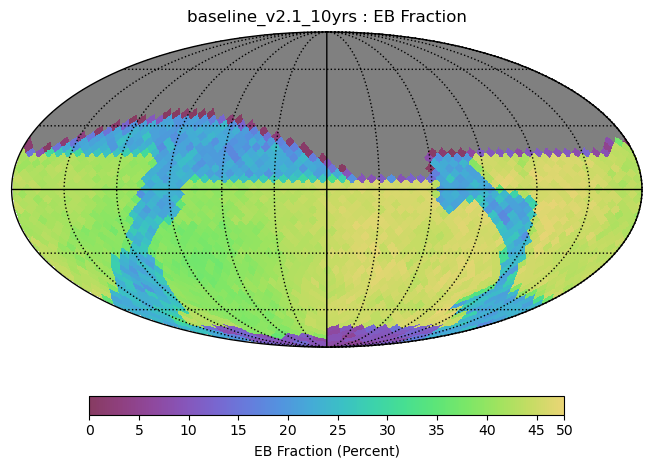

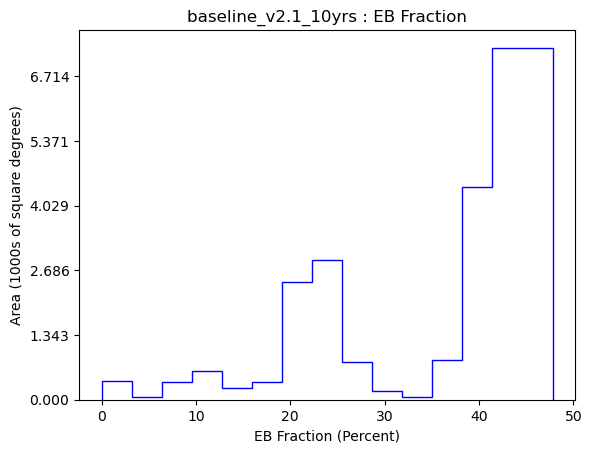

In [5]:
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [6]:
bundle_list[0].summary_values

{'Median': 41.8}

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


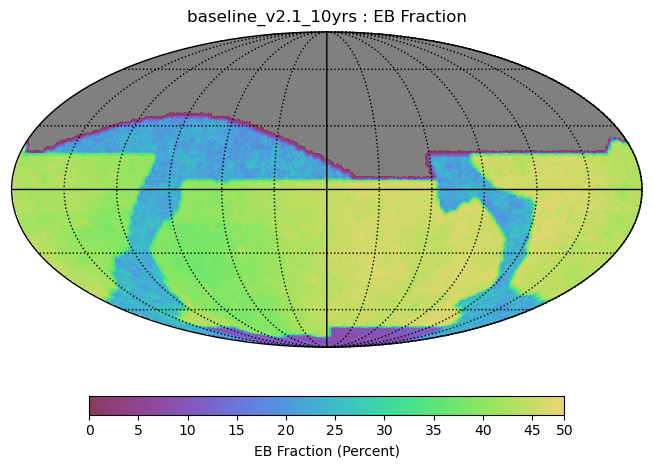

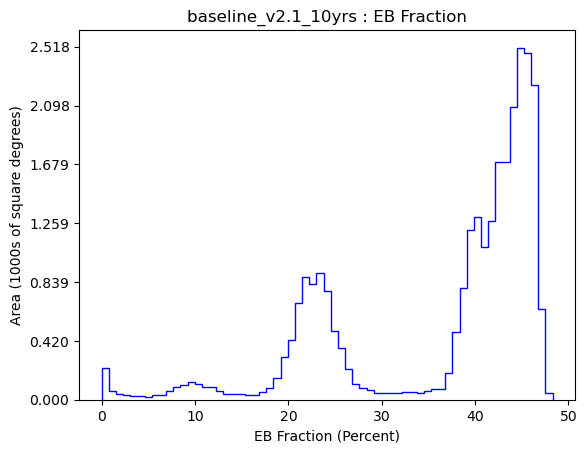

In [7]:
# ok, full resolution now, takes a few minutes to grind out
bundle_list = []
sql = ''
slicer = maf.HealpixSlicer()
metric = EclipsingBinaryMetric()
summary_stats = [maf.MedianMetric()]
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name, summary_metrics=summary_stats))
bundle_group = maf.MetricBundleGroup(bundle_list, baseline_file, out_dir='temp')
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [8]:
bundle_list[0].summary_values

{'Median': 41.699999999999996}

The potential ways to use this

* run the metric for a few different parameters (short, medium, long EBs with short medium, long eclipse times)
* could load up the stellar density maps and scale by that. Then the sum of these would scale with the number of detected EBs

This example runs over the full sky. We could also run over a sampling of points and see how well we do. 